In [1]:
import os
os.chdir(r"C:\Users\ashto\DAPPEr-main") #change directory to dapper-main folder
current_directory = os.getcwd()
print(f"Current directory: {current_directory}")

Current directory: C:\Users\ashto\DAPPEr-main


In [2]:
from src import *
from src.UDIP_Lib import *
import src.fitting.fit as R_fitting
import src.UDIP_Lib.UDIP_Lib_V19 as UDIP_Lib  #making updating UDIP_Lib easier
from src.RockSat_json.RockSat_json import import_data
import numpy as np
from scipy import signal
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d


In [3]:
df = pd.read_csv(r"data\ne 3.csv")
ne_data = df['ne']
ne_error = df['ne_err']
time = df['time'] - 57 #account for 57 sec filter
# sweeps 150-490 where we get good data (more like 175-470)

#filtering out bad values... initially i did this, but now showing lower altitudes cant do it
mask = ne_data > 1e2
ne_data_filtered = ne_data[mask]
ne_error_filtered = ne_error[mask]
time_filtered = time[mask]

C:\Users\ashto\AppData\Local\Temp\ipykernel_18028\1774732382.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  IRI_data = pd.read_csv(


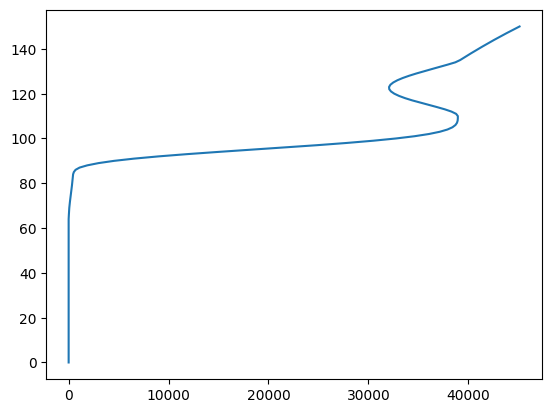

In [4]:
import pandas as pd

columns = ["km", "Ne/cm-3", "Ne/NmF2", "Tn/K", "Ti/K", "Te/K", "O+", "N+", "H+", "He+", "O2+", "NO+", "Clust", "TEC", "t/%"]
IRI_data = pd.read_csv(
    r"data\IRI Data.txt",
    skiprows=35,
    delim_whitespace=True,
    names=columns, 
    header=None
)

IRI_alt = IRI_data['km']
IRI_dens = IRI_data['Ne/cm-3']
plt.plot(IRI_dens,IRI_alt)


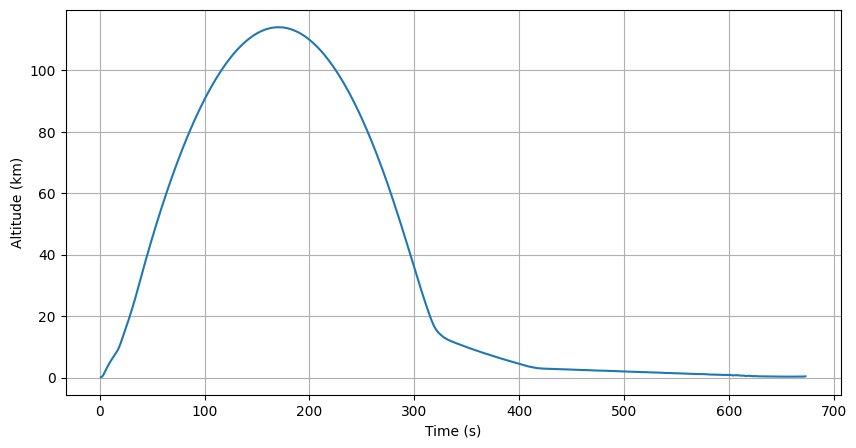

In [5]:
# extrapolate altitude data from rockon 
times_ROCK = []
altitudes_ROCK = []
lat_ROCK = []
long_ROCK = []
azimuth_ROCK = []

with open(r"C:\Users\ashto\DAPPEr2\UDIP4\data\NRW-6381 ROCKON 41.133 R18 POSDAT 06202024.txt", "r") as rockonData18: #R18
    next(rockonData18)  # Skip the header
    for line in rockonData18:
        parts = line.strip().split()
        times_ROCK.append(float(parts[1]))  # time values
        altitudes_ROCK.append(float(parts[9]) / 1000)  # altitude values in km
        lat_ROCK.append(float(parts[10]))
        long_ROCK.append(float(parts[11]))
        azimuth_ROCK.append(float(parts[3]))

plt.figure(figsize=(10, 5))
apogee = max(altitudes_ROCK)
plt.plot(times_ROCK,altitudes_ROCK)
plt.xlabel("Time (s)")
plt.ylabel("Altitude (km)")
plt.grid(True)

In [6]:
print(min(azimuth_ROCK), max(azimuth_ROCK))

111.8145 187.5923


Text(0, 0.5, 'azimuth')

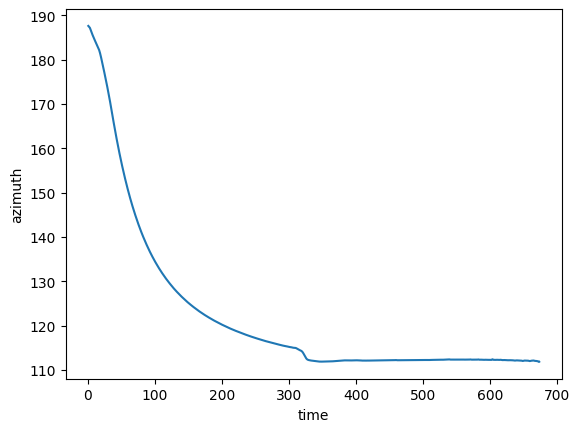

In [7]:
plt.plot(times_ROCK,azimuth_ROCK)
plt.xlabel("time")
plt.ylabel("azimuth")

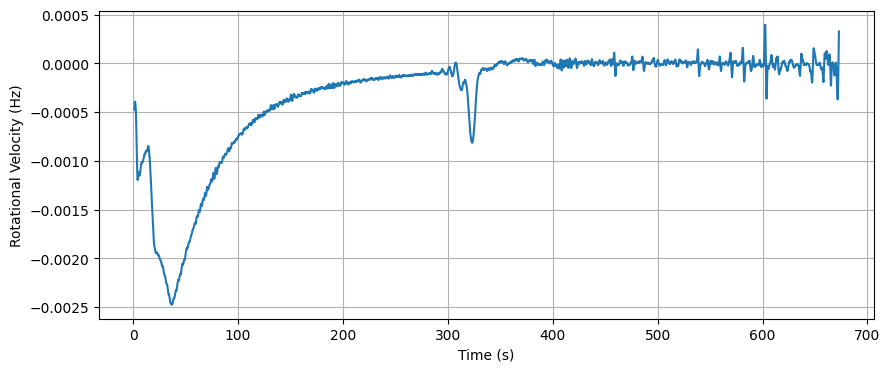

In [8]:
rot_vel_hz = []
times_mid = []

for i in range(1, len(times_ROCK)):
    dt = times_ROCK[i] - times_ROCK[i - 1]
    daz = azimuth_ROCK[i] - azimuth_ROCK[i - 1] #finding instantaneous daz/dt, rather than averaging azimuth/time
    hz = daz / (360 * dt) #convert to Hz
    rot_vel_hz.append(hz)
    times_mid.append((times_ROCK[i] + times_ROCK[i - 1]) / 2)

plt.figure(figsize=(10, 4))
plt.plot(times_mid, rot_vel_hz)
plt.xlabel("Time (s)")
plt.ylabel("Rotational Velocity (Hz)")
plt.grid(True)
#plt.axvline(37)

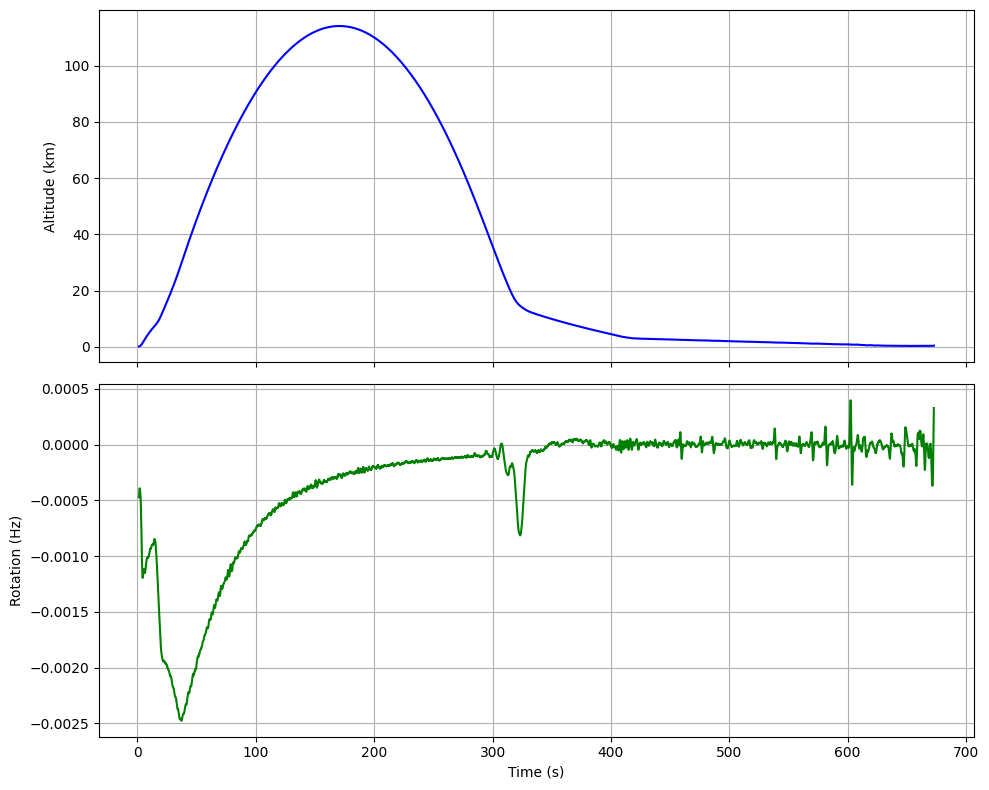

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Top plot: Altitude
axs[0].plot(times_ROCK, altitudes_ROCK, color='blue')
axs[0].set_ylabel("Altitude (km)")
axs[0].grid(True)

# Bottom plot: Rotational velocity
axs[1].plot(times_mid, rot_vel_hz, color='green')
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Rotation (Hz)")
axs[1].grid(True)
plt.tight_layout()
plt.show()


In [10]:
print("descent peak density altitude = 108.8 km.... find index, find long/lat", altitudes_ROCK[2028])
print("ascent peak density altitude = 110.4.... find index, find long/lat",altitudes_ROCK[1416])
print("descent lat:", lat_ROCK[2028], "descent long", long_ROCK[2028])
print("ascent lat:", lat_ROCK[1416], "ascent long", long_ROCK[1416])
peak_ascent_lat = lat_ROCK[1416]
peak_ascent_long = long_ROCK[1416]
peak_descent_lat = lat_ROCK[2028]
peak_descent_long = long_ROCK[2028]

descent peak density altitude = 108.8 km.... find index, find long/lat 108.807
ascent peak density altitude = 110.4.... find index, find long/lat 110.413
descent lat: 37.7478287 descent long -75.0369135
ascent lat: 37.7782792 ascent long -75.1787726


(-10000.0, 500000.0)

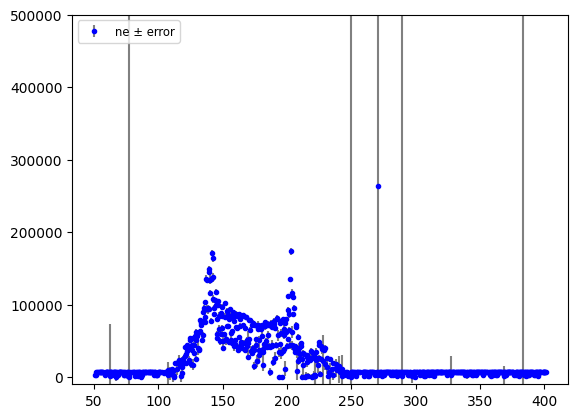

In [11]:
plt.errorbar(time_filtered, ne_data_filtered, yerr=ne_error_filtered, fmt='.',color='blue',ecolor='grey', label='ne ± error')
plt.legend(fontsize="small")
plt.ylim(-10000,5e5)

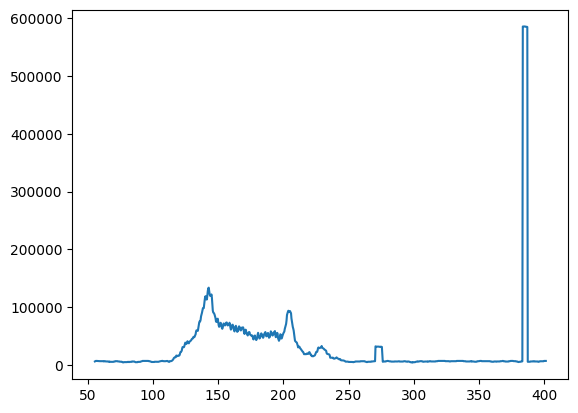

In [12]:
altitude_function = interp1d(times_ROCK, altitudes_ROCK) 
interpolated_altitudes = altitude_function(time_filtered)
#plt.scatter(ne_data,interpolated_altitudes)
apogee_value = np.where(interpolated_altitudes == apogee)[0][0] #cutting list at apogee to find temperatures going up

ne_data_avg = ne_data_filtered.rolling(10).mean() #rolling average
plt.plot(time_filtered,ne_data_avg)

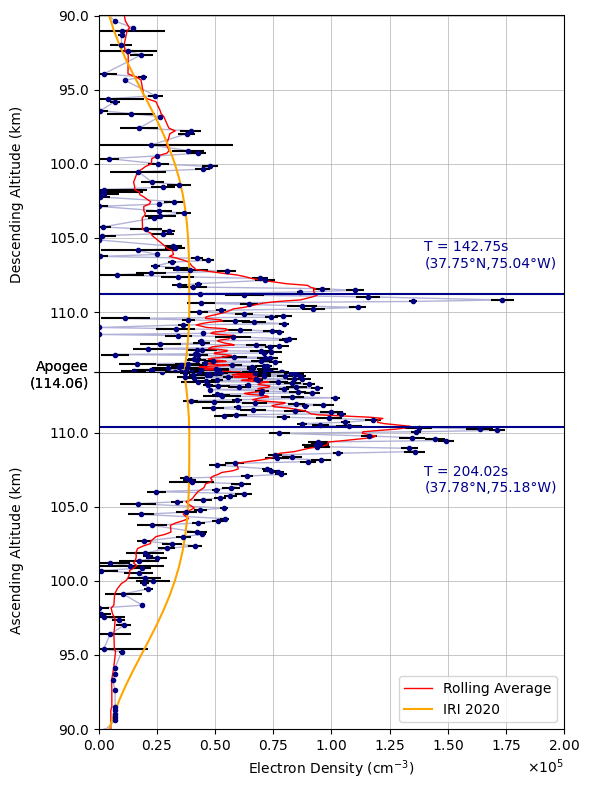

In [21]:
#stacked plot
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(6, 8), gridspec_kw={'hspace': 0})

#First subplot (descending)
ax1.errorbar(ne_data_filtered[apogee_value:], interpolated_altitudes[apogee_value:], 
             xerr=ne_error_filtered[apogee_value:],fmt='.', color='navy', ecolor='black', label='Density ± error')

ax1.plot(ne_data_filtered[apogee_value:], interpolated_altitudes[apogee_value:], 
         color='navy', alpha=0.3, linewidth=1, zorder=0)

ax1.plot(ne_data_avg[apogee_value:], interpolated_altitudes[apogee_value:], color='red', label="Rolling Average",lw=1)
ax1.plot(IRI_dens, IRI_alt,c='orange')

ax1.set_ylabel("Descending Altitude (km)")
ax1.invert_yaxis()  # Flip the y-axis so plot flows nicely
ax1.tick_params(labelbottom=False)  # Hide x-axis labels for the top plot (basically make the two plots into one with no space between, easier to the eye)


# Second subplot (ascending)
ax2.errorbar(ne_data_filtered[:apogee_value], interpolated_altitudes[:apogee_value],
              xerr=ne_error_filtered[:apogee_value],fmt='.', color='navy', ecolor='black')
ax2.plot(ne_data_filtered[:apogee_value], interpolated_altitudes[:apogee_value],
         color='navy', alpha=0.3, linewidth=1, zorder=0)

ax2.plot(ne_data_avg[:apogee_value], interpolated_altitudes[:apogee_value],label='Rolling Average', color='red',lw=1)
ax2.plot(IRI_dens,IRI_alt,c='orange', label="IRI 2020")
ax2.set_xlabel(r'Electron Density (cm$^{-3}$)')
ax2.set_ylabel("Ascending Altitude (km)")



#formatting and making the plot look nice
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))
ax2.xaxis.set_major_formatter(formatter)
ax1.set_xlim(0,2e5)
ax2.set_xlim(0,2e5)
ax1.set_ylim(apogee,90)
ax2.set_ylim(90,apogee)
yticks = np.arange(90, apogee, 5)
ax1.set_yticks(yticks)
ax2.set_yticks(yticks)
ax1.grid(linewidth=0.5)
ax2.grid(linewidth=0.5)
ax2.legend(loc="lower right")
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.axhline(apogee, c='black')

for ax in (ax1, ax2):
    ticks = np.append(ax.get_yticks(), apogee)
    ax.set_yticks(ticks)
    ax.set_yticklabels([f"Apogee\n({apogee})" if t == apogee else f"{t}" for t in ticks])

ax1.axhline(108.8, c='darkblue')
ax2.axhline(110.4, c='darkblue')
ax1.text(1.4e5, 107, f"T = 142.75s\n({peak_descent_lat:.2f}°N,{-peak_descent_long:.2f}°W)" , c='darkblue')
ax2.text(1.4e5, 106, f"T = 204.02s\n({peak_ascent_lat:.2f}°N,{-peak_ascent_long:.2f}°W)",c='darkblue') #these time values T are from Jarrod's notebook calculations

plt.tight_layout()
plt.show()


In [14]:
print(min(interpolated_altitudes[:apogee_value]))
print(min(interpolated_altitudes[apogee_value:]))

46.06378000000001
4.3450000000000015


In [15]:
mask = ne_data > 1e2
ne_over1000 = ne_data[mask]
ne_error_over1000 = ne_error[mask]
time_over1000 = time[mask]

altitudes_over1000 = altitude_function(time_over1000) # new altitude array to apply Lomb Scargle
alt_mask = altitudes_over1000 >= 110
time_high = time_over1000[alt_mask]
ne_high = ne_over1000[alt_mask]
ne_err_high = ne_error_over1000[alt_mask]

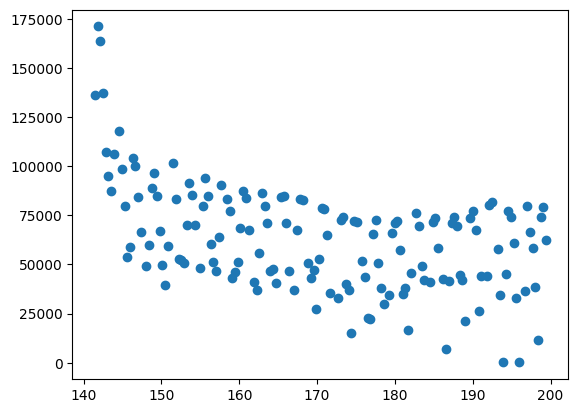

In [16]:
plt.scatter(time_high, ne_high)

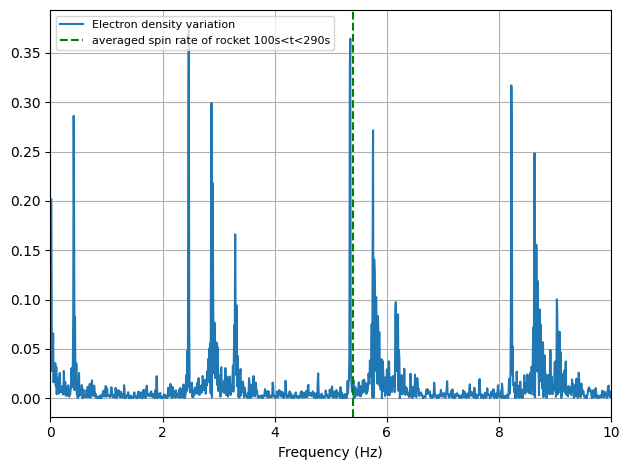

In [17]:
from scipy.signal import lombscargle
fmin = 0.1
fmax = 500.0
num_freqs = 10000
frequencies = np.linspace(fmin, fmax, num_freqs) # Frequency grid (rad/s), will convert to Hz in plot

pgram = lombscargle(time_high, ne_high, frequencies, floating_mean=True, normalize=True )
plt.plot(frequencies / (2 * np.pi), pgram, label='Electron density variation')
plt.xlabel("Frequency (Hz)")
plt.grid(True)
plt.xlim(0,10)
plt.tight_layout()
# plt.axvline(2.9, c='orange', ls='--')
# plt.axvline(2 * 2.9, c='orange', ls='--')
# plt.axvline(3 * 2.9, c='orange', ls='--')
# plt.axvline(4 * 2.9, c='orange', ls='--')
# plt.axvline(5 * 2.9, c='orange', ls='--')
plt.axvline(5.401007570656262, c='green', label='averaged spin rate of rocket 100s<t<290s', ls='--')
plt.legend(fontsize=8)
plt.show()